# Quads design (3dp pla + blue shims) for energy focusing with single target region


## Imports

In [ ]:
from difflexmm.utils import save_data, load_data
from difflexmm.geometry import QuadGeometry, compute_inertia
from difflexmm.plotting import generate_animation, plot_geometry
from problems.quads_focusing import ForwardProblem, OptimizationProblem
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, List

import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)  # enable float64 type
# config.update("jax_log_compiles", 1)

plt.style.use(["science", "grid"])
%matplotlib widget


## Plotting functions


In [2]:
def plot_objective_and_constraints_iterations(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, figsize=(10, 7), fontsize=None, grid=True):

    fig, axes = plt.subplots(nrows=3, figsize=figsize, sharex=True, constrained_layout=True)
    axes[0].set_ylabel("Energy focused [mJ]", fontsize=fontsize)
    axes[0].plot(jnp.array(optimization.objective_values) /
                 optimization.forward_problem.n_timepoints, lw=3, color="#16a085")
    axes[0].axhline(y=0, color="black")
    axes[1].set_ylabel("Overlap", fontsize=fontsize)
    axes[1].plot(optimization.constraints_violation["angles"], lw=3, color="#c0392b")
    axes[1].axhline(y=0, color="black")
    axes[2].set_ylabel("Edge-length [mm]", fontsize=fontsize)
    axes[2].plot(optimization.constraints_violation["edge_lengths"], lw=3, color="#c0392b")
    axes[2].axhline(y=0, color="black")
    axes[-1].set_xlabel(r"Iteration \#", fontsize=fontsize)
    # Change fontsize for all axes
    for ax in axes:
        ax.tick_params(labelsize=fontsize)
    if not grid:
        for ax in axes:
            ax.grid(False)

    if optimization_filename is not None:
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/objective_and_constraints_iterations.png")
        path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
        fig.savefig(str(path), dpi=300)


def plot_objective_iterations(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, figsize=(10, 7), fontsize=None, grid=True):

    fig, axes = plt.subplots(figsize=figsize, sharex=True, constrained_layout=True)
    axes.plot(jnp.array(optimization.objective_values) /
              optimization.forward_problem.n_timepoints, lw=3, color="#16a085")
    axes.axhline(y=0, color="black")
    axes.set_xlabel(r"Iteration \#", fontsize=fontsize)
    axes.set_ylabel("Energy focused [mJ]", fontsize=fontsize)
    # Change fontsize for all axes
    axes.tick_params(labelsize=fontsize)
    if not grid:
        axes.grid(False)

    if optimization_filename is not None:
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/objective_iterations.png")
        path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
        fig.savefig(str(path), dpi=300)


def energy_profile(velocity, blocks_inertia):
    # velocity is (n_time_steps, n_blocks, 3)
    # blocks_inertia is (n_blocks, 3)
    return 0.5*jnp.sum(velocity**2 * blocks_inertia, axis=-1)


def plot_energy_evolution(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, block_ids=None, figsize=(10, 7), fontsize=None, grid=True):

    fig, axes = plt.subplots(figsize=figsize, sharex=True, constrained_layout=True)
    _block_ids = block_ids if block_ids is not None else jnp.arange(
        optimization.forward_problem.solution_data.block_centroids.shape[0])
    energy_history = jnp.sum(
        energy_profile(
            optimization.forward_problem.solution_data.fields[:, 1, _block_ids, :],
            compute_inertia(vertices=optimization.forward_problem.solution_data.centroid_node_vectors,
                            density=optimization.forward_problem.density)
        ),
        axis=-1
    )
    axes.plot(
        optimization.forward_problem.solution_data.timepoints*1e3,
        energy_history,
        lw=3,
        color="#16a085"
    )
    axes.set_xlabel(r"Time [ms]", fontsize=fontsize)
    axes.set_ylabel("Kinetic energy [mJ]", fontsize=fontsize)
    # Change fontsize for all axes
    axes.tick_params(labelsize=fontsize)
    if not grid:
        axes.grid(False)

    if optimization_filename is not None:
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/energy_evolution.png")
        path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
        fig.savefig(str(path), dpi=300)


def plot_energy_evolution_list(optimization_list: List[OptimizationProblem], optimization_filename: Optional[str] = None, block_ids=None, figsize=(10, 7), fontsize=None, grid=True, labels=None):

    fig, axes = plt.subplots(figsize=figsize, sharex=True, constrained_layout=True)
    _block_ids = block_ids if block_ids is not None else jnp.arange(
        optimization_list[0].forward_problem.solution_data.block_centroids.shape[0])
    if block_ids == "target":
        target_size = optimization_list[0].target_size
        target_shift = optimization_list[0].target_shift
        _block_ids = jnp.array([
            j * optimization_list[0].forward_problem.n1_blocks + i
            for i in range((optimization_list[0].forward_problem.n1_blocks-target_size[0])//2 + target_shift[0], (optimization_list[0].forward_problem.n1_blocks+target_size[0])//2 + target_shift[0])
            for j in range((optimization_list[0].forward_problem.n2_blocks-target_size[1])//2 + target_shift[1], (optimization_list[0].forward_problem.n2_blocks+target_size[1])//2 + target_shift[1])
        ])

    labels = labels if labels is not None else [None]*len(optimization_list)
    for optimization, label in zip(optimization_list, labels):
        energy_history = jnp.sum(
            energy_profile(
                optimization.forward_problem.solution_data.fields[:, 1, _block_ids, :],
                compute_inertia(vertices=optimization.forward_problem.solution_data.centroid_node_vectors,
                                density=optimization.forward_problem.density)[_block_ids]
            ),
            axis=-1
        )
        axes.plot(
            optimization.forward_problem.solution_data.timepoints*1e3,
            energy_history,
            lw=2,
            label=label
        )
    axes.set_xlabel(r"Time [ms]", fontsize=fontsize)
    axes.set_ylabel("Kinetic energy [mJ]", fontsize=fontsize)
    axes.legend()
    # Change fontsize for all axes
    axes.tick_params(labelsize=fontsize)
    if not grid:
        axes.grid(False)

    if optimization_filename is not None:
        path = Path(
            f"../out/{optimization_list[0].name}/{optimization_filename}/energy_evolutions.png")
        path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
        fig.savefig(str(path), dpi=300)


def plot_energy_ratio_evolution_list(optimization_list: List[OptimizationProblem], optimization_filename: Optional[str] = None, figsize=(10, 7), fontsize=None, grid=True, labels=None):

    fig, axes = plt.subplots(figsize=figsize, sharex=True, constrained_layout=True)
    target_size = optimization_list[0].target_size
    target_shift = optimization_list[0].target_shift
    target_block_ids = jnp.array([
        j * optimization_list[0].forward_problem.n1_blocks + i
        for i in range((optimization_list[0].forward_problem.n1_blocks-target_size[0])//2 + target_shift[0], (optimization_list[0].forward_problem.n1_blocks+target_size[0])//2 + target_shift[0])
        for j in range((optimization_list[0].forward_problem.n2_blocks-target_size[1])//2 + target_shift[1], (optimization_list[0].forward_problem.n2_blocks+target_size[1])//2 + target_shift[1])
    ])
    not_target_block_ids = jnp.setdiff1d(
        jnp.arange(optimization_list[0].forward_problem.solution_data.block_centroids.shape[0]),
        target_block_ids
    )

    labels = labels if labels is not None else [None]*len(optimization_list)
    for optimization, label in zip(optimization_list, labels):
        energy_ratio_history = jnp.sum(
            energy_profile(
                optimization.forward_problem.solution_data.fields[:, 1, target_block_ids, :],
                compute_inertia(vertices=optimization.forward_problem.solution_data.centroid_node_vectors,
                                density=optimization.forward_problem.density)[target_block_ids]
            ),
            axis=-1
        )/jnp.sum(
            energy_profile(
                optimization.forward_problem.solution_data.fields[:, 1, not_target_block_ids, :],
                compute_inertia(vertices=optimization.forward_problem.solution_data.centroid_node_vectors,
                                density=optimization.forward_problem.density)[not_target_block_ids]
            ),
            axis=-1
        )
        axes.plot(
            optimization.forward_problem.solution_data.timepoints*1e3,
            energy_ratio_history,
            lw=2,
            label=label
        )
        # energy_target_history = jnp.sum(
        #     energy_profile(
        #         optimization.forward_problem.solution_data.fields[:, 1, target_block_ids, :],
        #         compute_inertia(vertices=optimization.forward_problem.solution_data.centroid_node_vectors,
        #                         density=optimization.forward_problem.density)[target_block_ids]
        #     ),
        #     axis=-1
        # )
        # energy_not_target_history = jnp.sum(
        #     energy_profile(
        #         optimization.forward_problem.solution_data.fields[:, 1, not_target_block_ids, :],
        #         compute_inertia(vertices=optimization.forward_problem.solution_data.centroid_node_vectors,
        #                         density=optimization.forward_problem.density)[not_target_block_ids]
        #     ),
        #     axis=-1
        # )
        # axes.plot(
        #     optimization.forward_problem.solution_data.timepoints*1e3,
        #     energy_target_history,
        #     lw=2,
        #     label=label
        # )
        # axes.plot(
        #     optimization.forward_problem.solution_data.timepoints*1e3,
        #     energy_not_target_history,
        #     lw=2,
        #     ls="--",
        #     label=label
        # )
    axes.set_xlabel(r"Time [ms]", fontsize=fontsize)
    axes.set_ylabel("K target / K rest", fontsize=fontsize)
    axes.legend()
    # Change fontsize for all axes
    axes.tick_params(labelsize=fontsize)
    if not grid:
        axes.grid(False)

    if optimization_filename is not None:
        path = Path(
            f"../out/{optimization_list[0].name}/{optimization_filename}/energy_ratio_evolutions.png")
        path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
        fig.savefig(str(path), dpi=300)


def generate_response_animation(
        optimization: OptimizationProblem,
        optimization_filename: str,
        animation_filename: str = "response_animation",
        iteration=-1,
        field: str = "v",
        **plot_kwargs):

    if not optimization.forward_problem.is_setup:
        optimization.forward_problem.setup()

    if iteration >= 0:
        solution = optimization.forward_problem.solve(
            optimization.design_values[iteration]
        )
    else:
        solution = optimization.forward_problem.solution_data if optimization.forward_problem.solution_data is not None else optimization.forward_problem.solve(
            optimization.design_values[iteration]
        )

    xlim, ylim = optimization.forward_problem.geometry.get_xy_limits(
        *optimization.design_values[iteration]) + optimization.forward_problem.spacing * jnp.array([[-1.25, 1.25], [-1., 1.]])

    iteration_label = iteration if iteration >= 0 else len(optimization.design_values) + iteration
    # Drop alien stuff from plot_kwargs
    plot_kwargs.pop("field", None)
    plot_kwargs.pop("animation_filename", None)
    plot_kwargs.pop("iteration", None)
    generate_animation(
        data=solution,
        field=field,
        out_filename=f"../out/{optimization.name}/{optimization_filename}/{animation_filename}_design_{iteration_label:03d}",
        deformed=True,
        xlim=xlim,
        ylim=ylim,
        **plot_kwargs
    )


def plot_design(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, iteration=-1, figsize=(10, 7), fontsize=None, grid=True, axis=True):

    if not optimization.forward_problem.is_setup:
        optimization.forward_problem.setup()

    xlim, ylim = optimization.forward_problem.geometry.get_xy_limits(
        *optimization.design_values[iteration]) + 0.25*optimization.forward_problem.spacing * jnp.array([[-1.5, 1.5], [-1, 1]])

    fig, axes = plot_geometry(
        block_centroids=optimization.forward_problem.geometry.block_centroids(*optimization.design_values[iteration]),
        centroid_node_vectors=optimization.forward_problem.geometry.centroid_node_vectors(
            *optimization.design_values[iteration]),
        bond_connectivity=optimization.forward_problem.geometry.bond_connectivity(),
        figsize=figsize,
        color="#2980b9",
        xlim=xlim,
        ylim=ylim,
    )
    axes.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
    axes.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
    # axes.set_aspect("equal")
    axes.tick_params(labelsize=fontsize)
    if not grid:
        axes.grid(False)
    if not axis:
        axes.axis("off")

    iteration_label = iteration if iteration >= 0 else len(optimization.design_values) + iteration
    if optimization_filename is not None:
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/design_{iteration_label:03d}.png")
        path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
        fig.savefig(str(path), dpi=300)


## Optimal design and response


In [3]:
# NOTE: Units are mm, N, s

# Geometrical params
n1_blocks = 24
n2_blocks = 16
spacing = 15.  # 1.0  # 15 mm
hinge_length = 0.15*spacing  # Same as bond length
initial_angle = 25*jnp.pi/180
horizontal_shifts, vertical_shifts = QuadGeometry(n1_blocks, n2_blocks, spacing=spacing, bond_length=hinge_length).get_design_from_rotated_square(
    angle=initial_angle,
)  # Initial design

# Mechanical params
k_stretch = 120.  # stretching stiffness 120. N/mm
k_shear = 1.19  # shearing stiffness 1.19 N/mm
k_rot = 1.50  # rotational stiffness 1.50 Nmm
density = 6.18e-9  # Mg/mm^2
# NOTE: Damping is assumed to be the same for all blocks as it is small enough that the inertia change during optimization is negligible.
# The reference is taken to be zero angle rotated square geometry.
# 0.36125, 0.02175026 = mass and inertia of a single square of zero angle and unitary spacing and density and 0.15 bond length.
damping = 0.0186 * jnp.array([
    2 * (0.36125 * density * spacing**2 * k_shear)**0.5,
    2 * (0.36125 * density * spacing**2 * k_shear)**0.5,
    2 * (0.02175026 * density * spacing**4 * k_rot)**0.5
]) * jnp.ones((n1_blocks*n2_blocks, 3))

# Dynamic loading
amplitude = 0.5 * spacing
loading_rate = 30.  # Hz loading frequency for dynamic input

# Forward problem
problem = ForwardProblem(
    # Geometrical params
    n1_blocks=n1_blocks,
    n2_blocks=n2_blocks,
    spacing=spacing,
    bond_length=hinge_length,
    # Mechanical params
    k_stretch=k_stretch,
    k_shear=k_shear,
    k_rot=k_rot,
    density=density,
    damping=damping,
    use_contact=True,
    k_contact=k_rot,
    min_angle=-15*jnp.pi/180,
    cutoff_angle=-10*jnp.pi/180,
    # Dynamic loading
    amplitude=amplitude,
    loading_rate=loading_rate,
    input_delay=0.1*loading_rate**-1,
    n_excited_blocks=2,
    loaded_side="left",
    input_shift=0,
    # Analysis params
    simulation_time=2*2*loading_rate**-1,  # 2*loading_rate**-1,  # s
    n_timepoints=200,
    # Solver tolerances
    atol=1e-4,
    # Problem name (folder name)
    name="quads_focusing_3dp_pla_shims",
)

# Optimization problem
target_size = (2, 2)
target_shift = (4, 5)
optimization = OptimizationProblem(
    forward_problem=problem,
    target_size=target_size,
    target_shift=target_shift,
    name=problem.name,
)

# problem_filename = f"quads{'_linearized_strains' if problem.linearized_strains else ''}_{problem.n1_blocks}x{problem.n2_blocks}_excited_blocks_{problem.n_excited_blocks}_amplitude_{problem.amplitude:.2f}_loading_rate_{problem.loading_rate:.2f}_input_shift_{problem.input_shift}_initial_angle_{initial_angle*180/jnp.pi:.1f}"
# optimization_filename = f"opt_with_angle_30_and_length_3_constraints_{problem_filename}_target_size_{optimization.target_size[0]}x{optimization.target_size[1]}_target_shift_{optimization.target_shift[0]}x{optimization.target_shift[1]}"
# Explore simulation time
problem_filename = f"quads{'_linearized_strains' if problem.linearized_strains else ''}_{problem.n1_blocks}x{problem.n2_blocks}_excited_blocks_{problem.n_excited_blocks}_amplitude_{problem.amplitude:.2f}_loading_rate_{problem.loading_rate:.2f}_input_shift_{problem.input_shift}_initial_angle_{initial_angle*180/jnp.pi:.1f}_simulation_time_{problem.simulation_time*loading_rate:.0f}"
optimization_filename = f"opt_with_angle_30_and_length_3_constraints_{problem_filename}_target_size_{optimization.target_size[0]}x{optimization.target_size[1]}_target_shift_{optimization.target_shift[0]}x{optimization.target_shift[1]}"


### Import most recent optimization object


In [4]:
optimization = OptimizationProblem.from_data(
    load_data(
        f"../data/{optimization.name}/{optimization_filename}.pkl",
    )
)


### Run optimization


In [ ]:
optimization.run_optimization_nlopt(
    # initial_guess=(horizontal_shifts, vertical_shifts),
    initial_guess=optimization.design_values[-1],
    n_iterations=80,
    min_block_angle=30*jnp.pi/180,
    min_void_angle=0*jnp.pi/180,
    min_edge_length=3.,  # mm
    max_time=2*60*60,  # 8 hour
    # lower_bound=-0.22*optimization.forward_problem.spacing,
    # upper_bound=0.22*optimization.forward_problem.spacing,
)

save_data(
    f"../data/{optimization.name}/{optimization_filename}.pkl",
    optimization.to_data()  # Optimization problem
)


## Plots


### Objective iterations

In [ ]:
plot_objective_and_constraints_iterations(
    optimization,
    optimization_filename=optimization_filename,
    figsize=(7, 6),
    fontsize=14,
)


### Target kinetic energy evolution


In [ ]:
plot_energy_evolution(
    optimization=optimization,
    # optimization_filename=optimization_filename,
    figsize=(8, 3),
    fontsize=14,
)


### Response animation


In [ ]:
# Initial design
generate_response_animation(
    optimization,
    field="v",  # Velocity field
    optimization_filename=optimization_filename,
    figsize=(8, 7.35*(optimization.forward_problem.n2_blocks)/optimization.forward_problem.n1_blocks),
    fontsize=14,
    fps=30,
    dpi=300,
    legend_label="Velocity [mm/s]",
    cmap="inferno",
    animation_filename="response_animation_no_grid",
    axis=False,
    iteration=0,
)


In [ ]:
# Best design
generate_response_animation(
    optimization,
    field="v",  # Velocity field
    optimization_filename=optimization_filename,
    figsize=(8, 7.35*(optimization.forward_problem.n2_blocks)/optimization.forward_problem.n1_blocks),
    fontsize=14,
    fps=30,
    dpi=300,
    legend_label="Velocity [mm/s]",
    cmap="inferno",
    animation_filename="response_animation_no_grid",
    axis=False,
    iteration=-1,
)


### Plot designs


In [ ]:
# Initial design
plot_design(
    optimization,
    optimization_filename=optimization_filename,
    iteration=0,
    figsize=(7, 7*(optimization.forward_problem.n2_blocks)/optimization.forward_problem.n1_blocks),
    fontsize=14,
    grid=False,
    axis=False,
)


In [ ]:
# Best design
plot_design(
    optimization,
    optimization_filename=optimization_filename,
    iteration=-1,
    figsize=(7, 7*(optimization.forward_problem.n2_blocks)/optimization.forward_problem.n1_blocks),
    fontsize=14,
    grid=False,
    axis=False,
)


In [ ]:
# Export all designs
for i in range(len(optimization.design_values)):
    plot_design(
        optimization,
        optimization_filename=f"{optimization_filename}/designs",
        iteration=i,
        figsize=(7, 7*(optimization.forward_problem.n2_blocks)/optimization.forward_problem.n1_blocks),
        fontsize=14,
        grid=False,
        axis=True,
    )


In [ ]:
# Export some snapshot designs
for i in [0, 4, 6, 9, 30, -1]:
    plot_design(
        optimization,
        optimization_filename=f"{optimization_filename}",
        iteration=i,
        figsize=(7, 7*(optimization.forward_problem.n2_blocks)/optimization.forward_problem.n1_blocks),
        fontsize=14,
        grid=False,
        axis=False,
    )


### Objective vs size of time window


In [4]:
simulation_times = [2, 4, 8, 16]
data_paths = [Path(
    f"../data/{optimization.name}/opt_with_angle_30_and_length_3_constraints_quads_24x16_excited_blocks_2_amplitude_7.50_loading_rate_30.00_input_shift_0_initial_angle_25.0_target_size_2x2_target_shift_4x5.pkl"
)]
data_paths = data_paths + [
    Path(f"../data/{optimization.name}/opt_with_angle_30_and_length_3_constraints_quads_24x16_excited_blocks_2_amplitude_7.50_loading_rate_30.00_input_shift_0_initial_angle_25.0_simulation_time_{simulation_time}_target_size_2x2_target_shift_4x5.pkl")
    for simulation_time in simulation_times[1:]
]
optimizations = [OptimizationProblem.from_data(load_data(path)) for path in data_paths]

integrated_energies = []
for optimization in optimizations:
    # Use the longest simulation time
    optimization.forward_problem.simulation_time = optimizations[-1].forward_problem.simulation_time
    # optimization.forward_problem.n_timepoints = 400
    optimization.setup_objective()
    obj = optimization.objective_fn(optimization.design_values[-1])
    integrated_energies.append(
        obj*optimization.forward_problem.simulation_time/optimization.forward_problem.n_timepoints
    )
    optimization.compute_best_forward()


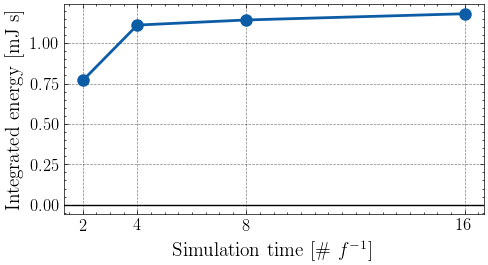

In [10]:
fig, ax = plt.subplots(figsize=(6, 3), constrained_layout=True)
ax.set_position([0.2, 0.2, 0.7, 0.7])
ax.plot(simulation_times, integrated_energies, 'o-', lw=2, ms=8)
ax.axhline(0, lw=1, color='black')
ax.set_xlabel(r"Simulation time [\# $f^{-1}$]", fontsize=14)
ax.set_ylabel(r"Integrated energy [mJ s]", fontsize=14)
# ax.set_title("Integrated energy vs. simulation time", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_xticks(simulation_times)
fig.savefig(f"../out/{optimization.name}/opt_with_angle_30_and_length_3_constraints_quads_24x16_excited_blocks_2_amplitude_7.50_loading_rate_30.00_input_shift_0_initial_angle_25.0_target_size_2x2_target_shift_4x5/integrated_energy_vs_simulation_time.png", dpi=300)
fig.savefig(f"../out/{optimization.name}/opt_with_angle_30_and_length_3_constraints_quads_24x16_excited_blocks_2_amplitude_7.50_loading_rate_30.00_input_shift_0_initial_angle_25.0_target_size_2x2_target_shift_4x5/integrated_energy_vs_simulation_time.pdf", dpi=300)


### Kinetic energy evolution vs size of time window


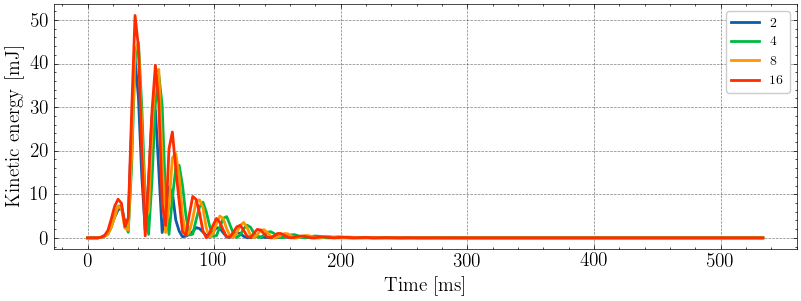

In [16]:
plot_energy_evolution_list(
    optimizations,
    labels=simulation_times,
    figsize=(8, 3),
    fontsize=14,
    block_ids="target",
    optimization_filename="opt_with_angle_30_and_length_3_constraints_quads_24x16_excited_blocks_2_amplitude_7.50_loading_rate_30.00_input_shift_0_initial_angle_25.0_target_size_2x2_target_shift_4x5"
)
